# 1. Business Problem

## 1.1 Problem Description

The dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories. So by building advanced state of the art NLP models will help us classify these reviews more accurately.

## 1.2 Problem Statement

The Amazon Fine Food Review dataset is taken from Kaggle and using plain text reviews the challange is to distinguish sentiment of the review as it is positive or negative review.

Dataset : https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

## 1.3 Business Metric

We will be using AUC Score as our performance metric.

# 2. Importing necessary files and libraries

In [ ]:
# importing important libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import pickle
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords 
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,Embedding,Dropout,LSTM,SpatialDropout1D,Bidirectional
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [ ]:
# loading csv file
reviews = pd.read_csv("Reviews.csv")
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
reviews.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [ ]:
# checking NAN values in dataset
reviews.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

# 3. Data Cleaning

## 3.1 Droping Unnecessary Columns

Getting only Score and Text column as we have to only deal with Text feature

In [ ]:
# getting only 2 columns - Text, Score
reviews = reviews.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary'], axis = 1)
reviews.head(2)

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...


In [ ]:
reviews.shape

(568454, 2)

## 3.2 Droping Rows having Score equal to 3

Here the main objective of the dataset is to predict whether a review is Positive or Negative.

The Score Columns has values 1,2,3,4,5. So to review a text as positive or negative we will consider Score equal to 1 and 2 as Negative Review and 4 and 5 as Positive Review, but for score equal to 3 we will consider it as netural review.

And then we will delete all the Neutral rows.

i.e.

If score > 3, then score = 1

If score <= 2, then score = 0

If score == 3, remove the rows. 

In [ ]:
# Removing rows with score = 3
reviews = reviews.drop(reviews[reviews['Score'] == 3].index.tolist(), axis = 0)
reviews.shape

(525814, 2)

In [ ]:
# Replacing Score = 1 and 2 with 0 represented as negative
# Replacing Score = 4 and 5 with 1 represented as positive
reviews = reviews.replace({'Score' : {1 : 0, 2 : 0, 4 : 1, 5 : 1}})
reviews.shape

(525814, 2)

## 3.3 Droping Duplicate Rows

Droping all the Duplicate Text as it could give biased results.

In [ ]:
# checking for any duplicate in Text Column
duplicate_bool = reviews.duplicated(['Text'])
print("There are {} duplicate Text in the dataset.".format(sum(duplicate_bool)))

There are 161978 duplicate Text in the dataset.


In [ ]:
# droping duplicate rows 
reviews = reviews.drop_duplicates(subset={"Text"})
reviews.shape

(363836, 2)

In [ ]:
reviews.head()

,Score,Text
0,1,I have bought several of the Vitality canned d...
1,0,Product arrived labeled as Jumbo Salted Peanut...
2,1,This is a confection that has been around a fe...
3,0,If you are looking for the secret ingredient i...
4,1,Great taffy at a great price. There was a wid...


## 3.4 Cleaning Text Column

In [ ]:
# Removing HTML from the Text column and save in the Text column only

# text cleaning
reviews = reviews.replace({'Text' : r'won\'t'}, {'Text' : 'will not'}, regex = True)
reviews = reviews.replace({'Text' : r'can\'t'}, {'Text' : 'can not'}, regex = True)
reviews = reviews.replace({'Text' : r'\'t'}, {'Text' : ' not'}, regex = True)
reviews = reviews.replace({'Text' : r'\'re'}, {'Text' : ' are'}, regex = True)
reviews = reviews.replace({'Text' : r'\'s'}, {'Text' : ' is'}, regex = True)
reviews = reviews.replace({'Text' : r'\'d'}, {'Text' : ' would'}, regex = True)
reviews = reviews.replace({'Text' : r'\'ll'}, {'Text' : ' have'}, regex = True)
reviews = reviews.replace({'Text' : r'\'m'}, {'Text' : ' am'}, regex = True)

# replacing all HTML forms from Text column
reviews = reviews.replace({'Text' : r'[^a-zA-Z]'}, {'Text' : ' '}, regex = True)
reviews = reviews.replace({'Text' : r'<[^<>]+>#'}, {'Text' : ' '}, regex = True)
reviews = reviews.replace({'Text' : r' br '}, {'Text' : ' '}, regex = True)

# lowering all alphabets in Text column
reviews.Text = reviews.Text.str.lower()

reviews.head()

,Score,Text
0,1,i have bought several of the vitality canned d...
1,0,product arrived labeled as jumbo salted peanut...
2,1,this is a confection that has been around a fe...
3,0,if you are looking for the secret ingredient i...
4,1,great taffy at a great price there was a wid...


# 4. Data Sampling and Data Splitting

## 4.1 Data Sampling

We are sampling the data based on word lenght of reviews beacause it is computationally very expensive to train a model on a local system with complete dataset.

In [ ]:
# sampling data with word length of reviews is less than or equal to 50
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<=50]
reviews.shape

(161713, 3)

In [ ]:
reviews.head()

,Score,Text,len
0,1,i have bought several of the vitality canned d...,48
1,0,product arrived labeled as jumbo salted peanut...,32
3,0,if you are looking for the secret ingredient i...,41
4,1,great taffy at a great price there was a wid...,27
7,1,this taffy is so good it is very soft and ch...,24


## 4.2 Data Splitting

In [ ]:
# split the data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(reviews['Text'].values, reviews['Score'].values, test_size = 0.20, random_state = 33, stratify = reviews['Score'].values)
print("X_train length :",len(X_train))
print("X_test length :",len(X_test))

X_train length : 129370
X_test length : 32343


# 5. Exploratory Data Analysis (EDA)

## 5.1 Plotting Count graph for Positive and Negative Review

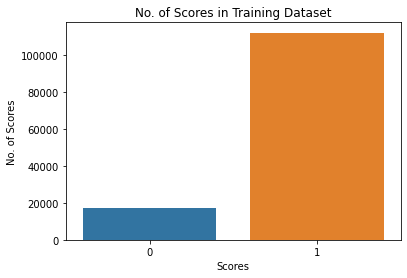

In [ ]:
# Plotting Bar Plot of y_train
sns.countplot(y_train)
plt.title('No. of Scores in Training Dataset')
plt.xlabel('Scores')
plt.ylabel('No. of Scores')
plt.show()

## 5.2 Distribution of Words for each type of review 

In [ ]:
# creating dataframe with text length for plotting
train_df = pd.DataFrame()
train_df['Text'] = X_train
train_df['Score'] = y_train
def get_wordlen(x):
    return len(x.split())
train_df['len'] = train_df.Text.apply(get_wordlen)
train_df.head()

,Text,Score,len
0,don not hesitate to buy this olive oil this ...,1,32
1,who would have thought i would need to go to a...,1,36
2,it just came in and to my disappointment it ...,1,40
3,stevia is great stuff and this effervescent t...,1,31
4,i ve tried several different decaf k cups and ...,1,31


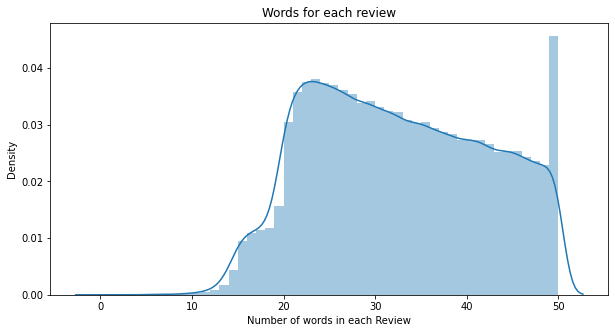

In [ ]:
# plotting PDF of total number of words in each review
plt.figure(figsize=(10,5))
sns.distplot(train_df['len'].values)
plt.title('Words for each review')
plt.xlabel('Number of words in each Review')
plt.show()

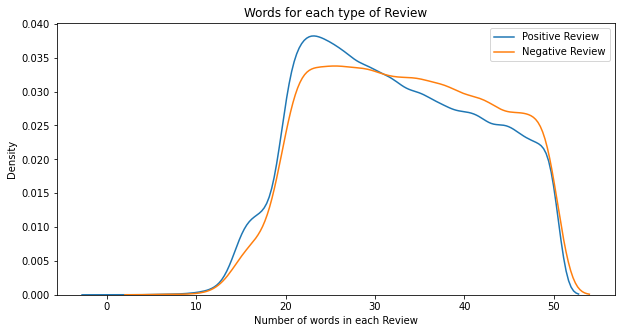

In [ ]:
# plotting PDF of total number of words in each type of review
plt.figure(figsize=(10,5))
sns.distplot(train_df[train_df['Score']==1]['len'], hist=False, label="Positive Review")
sns.distplot(train_df[train_df['Score']==0]['len'], hist=False, label="Negative Review")
plt.title('Words for each type of Review')
plt.xlabel('Number of words in each Review')
plt.legend()
plt.show()

It can be observe that there is some variation between PDF word count of positive and negative review.

## 5.3 Plotting Word Cloud

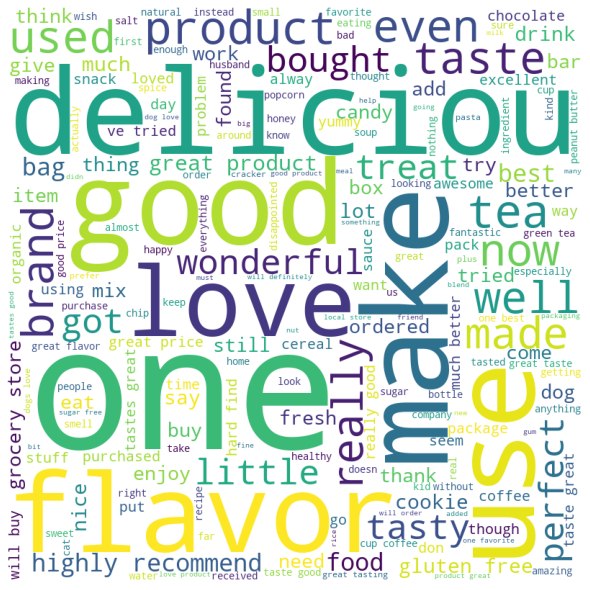

In [ ]:
#Plotting the WordCloud fo all the false positive data points
from wordcloud import WordCloud, STOPWORDS
review_words = ''
stopwords = set(STOPWORDS)

for review in train_df['Text'].values:
    tokens = review.split()
    review_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,background_color='white',stopwords = stopwords, min_font_size = 5).generate(review_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# 6. NLP Models

Using LSTM, Bi-Directional LSTM and BERT model for traininng our dataset and choosing the model with best AUC Score.

## 6.1 LSTM Model

Building and training a LSTM model with pretrained W2V weights.

### 6.1.1 Text Tokenizing 

In [ ]:
# performoing tokenization on X_train
tokenizer  = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(X_train)
words = tokenizer.word_index
words_length = len(words) + 1
words_length

40764

In [ ]:
# tokenizing train and test array 
X_train_tokenizer = tokenizer.texts_to_sequences(X_train)
X_test_tokenizer = tokenizer.texts_to_sequences(X_test)

# performing padding
X_train_pad = pad_sequences(X_train_tokenizer, maxlen = 50, padding = 'post')
X_test_pad = pad_sequences(X_test_tokenizer, maxlen = 50, padding = 'post')

In [ ]:
# Downloaading glove vector 
# !wget http://nlp.stanford.edu/data/glove.6B.zip

# Unzipping glove vector
# !unzip glove.6B.zip

In [ ]:
# creating dictonary of word with its vector
glove_vector = dict()
with open("glove.6B.100d.txt", "r", encoding = 'ISO-8859-1') as file:
    for i in tqdm(file):
        values = i.split()
        word = values[0]
        vector = np.array(values[1:])
        glove_vector[word] = vector

# creating word vector array 
vec_size = 100
word_vector = np.zeros((words_length, vec_size))
for word,index in tokenizer.word_index.items():
    vec = glove_vector.get(word)
    if vec is not None:
        word_vector[index] = vec

400000it [00:12, 32859.03it/s]


### 6.1.2 Training LSTM Model

In [ ]:
# constructing LSTM Model flow architecture
# Input layer
input_layer = Input(shape=(50,))

# Embedding layer
embedded_layer = Embedding(words_length, vec_size, input_length = 50, weights = [word_vector], trainable = False)(input_layer)

spatial_dropout_layer = SpatialDropout1D(0.3)(embedded_layer)

# Lstm layer
lstm_layer = LSTM(100)(spatial_dropout_layer)

# Dense hidden layer
layer_1 = Dense(128, activation = 'relu')(lstm_layer)
layer_2 = Dense(64, activation = 'relu')(layer_1)
layer_3 = Dense(32, activation = 'relu')(layer_2)

# output layer
output = Dense(1, activation = 'sigmoid')(layer_3)

# Creating model
model_lstm = Model(inputs = input_layer, outputs = output)

model_lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 100)           4076400   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 128)               12928     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                             

In [ ]:
# training LSTM model
earlystop = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
lr_reduced = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4, patience = 2)

checkpoints = ModelCheckpoint(filepath = "best_model_lstm.hdf5", monitor = 'val_auc', save_best_only = True, mode = 'max')

callback_list = [lr_reduced, earlystop, checkpoints]

model_lstm.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = [tf.keras.metrics.AUC()])

history_lstm = model_lstm.fit(X_train_pad, y_train, epochs = 20, validation_data = (X_test_pad, y_test), batch_size = 16, callbacks = callback_list) 

Epoch 1/20
8086/8086 [==============================] - 66s 8ms/step - loss: 0.3004 - auc: 0.8121 - val_loss: 0.1829 - val_auc: 0.9476 - lr: 0.0010
Epoch 2/20
8086/8086 [==============================] - 62s 8ms/step - loss: 0.1878 - auc: 0.9425 - val_loss: 0.1559 - val_auc: 0.9631 - lr: 0.0010
Epoch 3/20
8086/8086 [==============================] - 62s 8ms/step - loss: 0.1603 - auc: 0.9589 - val_loss: 0.1432 - val_auc: 0.9675 - lr: 0.0010
Epoch 4/20
8086/8086 [==============================] - 65s 8ms/step - loss: 0.1461 - auc: 0.9657 - val_loss: 0.1386 - val_auc: 0.9697 - lr: 0.0010
Epoch 5/20
8086/8086 [==============================] - 62s 8ms/step - loss: 0.1368 - auc: 0.9701 - val_loss: 0.1269 - val_auc: 0.9736 - lr: 0.0010
Epoch 6/20
8086/8086 [==============================] - 62s 8ms/step - loss: 0.1313 - auc: 0.9724 - val_loss: 0.1215 - val_auc: 0.9762 - lr: 0.0010
Epoch 7/20
8086/8086 [==============================] - 61s 8ms/step - loss: 0.1251 - auc: 0.9748 - val_loss: 0.

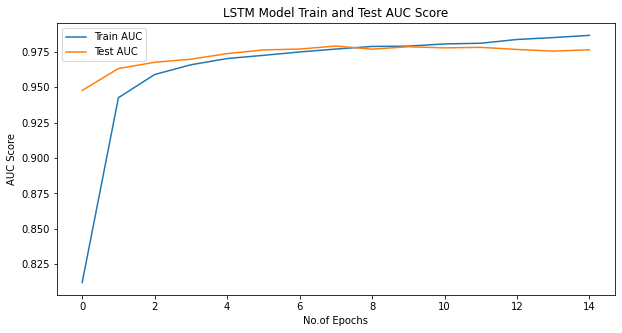

In [ ]:
# plotting LSTM Model AUC Score history
fig, ax = plt.subplots(figsize = (10,5))
hist_1 = history_lstm.history
plt.plot(range(len(hist_1["auc"])), hist_1["auc"], label = "Train AUC")
plt.plot(range(len(hist_1["val_auc"])), hist_1["val_auc"], label = "Test AUC")
plt.title('LSTM Model Train and Test AUC Score')
plt.xlabel('No.of Epochs')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

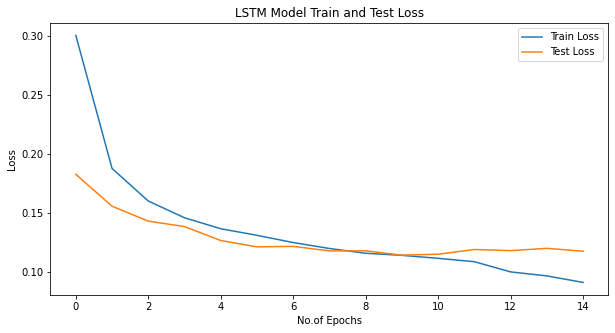

In [ ]:
# plotting LSTM Model Loss history
fig, ax = plt.subplots(figsize = (10,5))
hist_1 = history_lstm.history
plt.plot(range(len(hist_1["loss"])), hist_1["loss"], label = "Train Loss")
plt.plot(range(len(hist_1["val_loss"])), hist_1["val_loss"], label = "Test Loss")
plt.title('LSTM Model Train and Test Loss')
plt.xlabel('No.of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 6.2 Bi-Directional LSTM

Building and training Bi-Directional LSTM model with pretrained W2V weights.

In [ ]:
# creating Bi-Directional LSTM Model flow architecture
# Input layer
input_layer = Input(shape=(50,))

# Embedding layer
embedded_layer = Embedding(words_length, vec_size, input_length = 50, weights = [word_vector], trainable = False)(input_layer)

dropout_layer = SpatialDropout1D(0.3)(embedded_layer)
bidirectional_lstm_layer = Bidirectional(LSTM(100, dropout=0.3))(dropout_layer)

dense_layer_1 = Dense(512, activation='relu')(bidirectional_lstm_layer)
dropout_layer_1 = Dropout(0.8)(dense_layer_1)

dense_layer_2 = Dense(256, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(0.8)(dense_layer_2)

# output layer
output = Dense(1, activation = 'sigmoid')(dropout_layer_2)

# Creating model
model_bidirectional_lstm = Model(inputs = input_layer, outputs = output)

model_bidirectional_lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 100)           4076400   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 100)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               102912    
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [ ]:
# training bidirectional lstm model
earlystop = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
lr_reduced = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4, patience = 2)

checkpoints = ModelCheckpoint(filepath = "best_model_bidirectional_lstm.hdf5", monitor = 'val_auc', save_best_only = True, mode = 'max')

callback_list = [lr_reduced, earlystop, checkpoints]

model_bidirectional_lstm.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = [tf.keras.metrics.AUC()])

history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train_pad, y_train, epochs = 20, validation_data = (X_test_pad, y_test), batch_size = 16, callbacks = callback_list)

Epoch 1/20
8086/8086 [==============================] - 95s 11ms/step - loss: 0.2970 - auc: 0.8408 - val_loss: 0.2065 - val_auc: 0.9392 - lr: 0.0010
Epoch 2/20
8086/8086 [==============================] - 90s 11ms/step - loss: 0.2433 - auc: 0.9031 - val_loss: 0.1757 - val_auc: 0.9522 - lr: 0.0010
Epoch 3/20
8086/8086 [==============================] - 89s 11ms/step - loss: 0.2256 - auc: 0.9195 - val_loss: 0.1824 - val_auc: 0.9555 - lr: 0.0010
Epoch 4/20
8086/8086 [==============================] - 89s 11ms/step - loss: 0.2121 - auc: 0.9300 - val_loss: 0.1675 - val_auc: 0.9643 - lr: 0.0010
Epoch 5/20
8086/8086 [==============================] - 89s 11ms/step - loss: 0.2045 - auc: 0.9357 - val_loss: 0.1455 - val_auc: 0.9691 - lr: 0.0010
Epoch 6/20
8086/8086 [==============================] - 88s 11ms/step - loss: 0.1982 - auc: 0.9406 - val_loss: 0.1540 - val_auc: 0.9685 - lr: 0.0010
Epoch 7/20
8086/8086 [==============================] - 88s 11ms/step - loss: 0.1950 - auc: 0.9423 - val_l

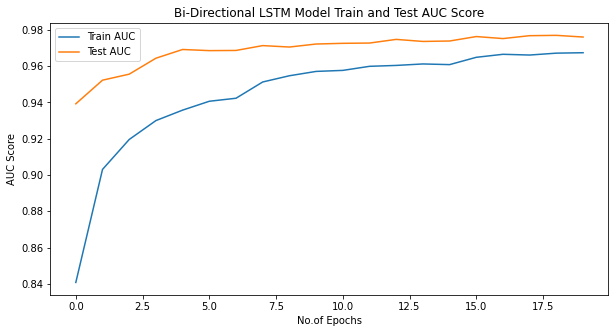

In [ ]:
# plotting Bi-Directional LSTM Model AUC Score history
fig, ax = plt.subplots(figsize = (10,5))
hist_2 = history_bidirectional_lstm.history
plt.plot(range(len(hist_2["auc"])), hist_2["auc"], label = "Train AUC")
plt.plot(range(len(hist_2["val_auc"])), hist_2["val_auc"], label = "Test AUC")
plt.title('Bi-Directional LSTM Model Train and Test AUC Score')
plt.xlabel('No.of Epochs')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

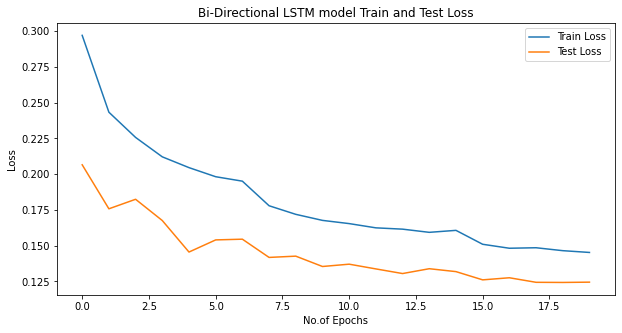

In [ ]:
# plotting Bi-Directional LSTM Model Loss history
fig, ax = plt.subplots(figsize = (10,5))
hist_2 = history_bidirectional_lstm.history
plt.plot(range(len(hist_2["loss"])), hist_2["loss"], label = "Train Loss")
plt.plot(range(len(hist_2["val_loss"])), hist_2["val_loss"], label = "Test Loss")
plt.title('Bi-Directional LSTM model Train and Test Loss')
plt.xlabel('No.of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 6.3 BERT (Bidirectional Encoder Representations from Transformers)

We will be using Bidirectional Encoder Representations from Transformers (BERT) uncased Base model.

<a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

### 6.3.1 Creating Bert Model

In [ ]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# initializing maximum length of a seq in the data 
max_seq_length = 50

## BERT takes 3 inputs

# this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

# mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

# creating segment vector using maximum sequence length
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

# bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

# using only pooled output for Bert model
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 50, 768)]                 'input_mask[0][0]',         

### 6.3.2 Text Tokenizing for BERT Model

In [ ]:
# installing text tokenizer library
!pip install sentencepiece

# getting tokenization.py file from https://github.com/google-research/bert/blob/master/tokenization.py
import tokenization 

In [ ]:
# getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

# tokenizing the vocab files
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case )

#### 6.3.2.1 Creating X_train_tokens, X_train_mask, X_train_segment

In [ ]:
# creating train tokens
train_tokens = []
for i in tqdm(range(len(X_train))):
    train_tokens.append(tokenizer.tokenize(X_train[i]))

100%|██████████| 129370/129370 [01:23<00:00, 1543.23it/s]


In [ ]:
# we are limitinng train token lenght to "max_seq_length - 2"
# max_seq_length = 50
train_tokens_new = []
for i in tqdm(range(len(train_tokens))):
    if len(train_tokens[i]) > (max_seq_length - 2):
        train_tokens_new.append(train_tokens[i][0 : (max_seq_length - 2)])
    else:
        train_tokens_new.append(train_tokens[i])

100%|██████████| 129370/129370 [00:00<00:00, 197137.32it/s]


In [ ]:
# adding '[CLS]' at the start and '[SEP]' at the end of each train tokens
train_tokens_with_cls_sep = []
for i in tqdm(range(len(train_tokens_new))):
    train_tokens_with_cls_sep.append(['[CLS]', *train_tokens_new[i], '[SEP]'])

100%|██████████| 129370/129370 [00:00<00:00, 204450.79it/s]


In [ ]:
# we are padding to train tokens by adding '[PAD]'  
for i in tqdm(range(len(train_tokens_with_cls_sep))):
    if len(train_tokens_with_cls_sep[i]) < 50:
        for j in range(50 - len(train_tokens_with_cls_sep[i])):
            train_tokens_with_cls_sep[i].append('[PAD]')

100%|██████████| 129370/129370 [00:00<00:00, 393598.97it/s]


In [ ]:
# coverting tokens to ids for X_train_tokens
X_train_tokens = []
for i in range(len(train_tokens_with_cls_sep)):
    X_train_tokens.append(tokenizer.convert_tokens_to_ids(train_tokens_with_cls_sep[i]))

# creating X_train_mask by replacing 1 for real token, 0 for '[PAD]'
X_train_mask = []
for i in tqdm(range(len(train_tokens_with_cls_sep))):
    mask = []
    for j in range(len(train_tokens_with_cls_sep[i])):
        if train_tokens_with_cls_sep[i][j] == '[PAD]':
            mask.append(0)
        else:
            mask.append(1)
    X_train_mask.append(mask)

100%|██████████| 129370/129370 [00:01<00:00, 85353.35it/s]


In [ ]:
# converting list to numpy array
X_train_tokens = np.array(X_train_tokens)
X_train_mask = np.array(X_train_mask)

# creating a segment input for train 
X_train_segment = np.zeros(np.array(X_train_mask).shape)

#### 6.3.2.2 Creating X_test_tokens, X_test_mask, X_test_segment

In [ ]:
# creating test tokens
test_tokens = []
for i in tqdm(range(len(X_test))):
    test_tokens.append(tokenizer.tokenize(X_test[i]))

100%|██████████| 32343/32343 [00:17<00:00, 1852.97it/s]


In [ ]:
# we are limitinng test token lenght to "max_seq_length - 2"
test_tokens_new = []
for i in tqdm(range(len(test_tokens))):
    if len(test_tokens[i]) > (max_seq_length - 2):
        test_tokens_new.append(test_tokens[i][0 : (max_seq_length - 2)])
    else:
        test_tokens_new.append(test_tokens[i])

100%|██████████| 32343/32343 [00:00<00:00, 1047119.10it/s]


In [ ]:
# adding '[CLS]' at the start and '[SEP]' at the end of each test tokens
test_tokens_with_cls_sep = []
for i in tqdm(range(len(test_tokens_new))):
    test_tokens_with_cls_sep.append(['[CLS]', *test_tokens_new[i], '[SEP]'])

100%|██████████| 32343/32343 [00:00<00:00, 55813.31it/s]


In [ ]:
# we are padding to test tokens by adding '[PAD]'  
for i in tqdm(range(len(test_tokens_with_cls_sep))):
    if len(test_tokens_with_cls_sep[i]) < 50:
        for j in range(50 - len(test_tokens_with_cls_sep[i])):
            test_tokens_with_cls_sep[i].append('[PAD]')

100%|██████████| 32343/32343 [00:00<00:00, 363186.61it/s]


In [ ]:
# coverting tokens to ids for X_test_tokens
X_test_tokens = []
for i in range(len(test_tokens_with_cls_sep)):
    X_test_tokens.append(tokenizer.convert_tokens_to_ids(test_tokens_with_cls_sep[i]))

# creating X_test_mask by replacing 1 for real token, 0 for '[PAD]'
X_test_mask = []
for i in tqdm(range(len(test_tokens_with_cls_sep))):
    mask = []
    for j in range(len(test_tokens_with_cls_sep[i])):
        if test_tokens_with_cls_sep[i][j] == '[PAD]':
            mask.append(0)
        else:
            mask.append(1)
    X_test_mask.append(mask)

100%|██████████| 32343/32343 [00:00<00:00, 85574.50it/s]


In [ ]:
# converting list to numpy array
X_test_tokens = np.array(X_test_tokens)
X_test_mask = np.array(X_test_mask)

# creating a segment input for test
X_test_segment = np.zeros(np.array(X_test_mask).shape)

### 6.3.3 Getting Embeddings from BERT Model

We will be using the BERT model and input data to get the embeddings for each sentence in the Train and Test dataset.

In [ ]:
bert_model.input

[<KerasTensor: shape=(None, 50) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 50) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 50) dtype=int32 (created by layer 'segment_ids')>]

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [ ]:
# getting the train embedding output using BERT model
X_train_pooled_output = bert_model.predict([X_train_tokens, X_train_mask, X_train_segment])

# getting the test embedding output using BERT model
X_test_pooled_output = bert_model.predict([X_test_tokens, X_test_mask, X_test_segment])

In [ ]:
# saving X_train_pooled_output and X_test_pooled_output in pickle file
pickle.dump((X_train_pooled_output),open('X_train_pooled_output.pkl','wb'))
pickle.dump((X_test_pooled_output),open('X_test_pooled_output.pkl','wb'))

In [ ]:
# loading X_train_pooled_output and X_test_pooled_output from pickle file
X_train_pooled_output = pickle.load(open('X_train_pooled_output.pkl', 'rb'))
X_test_pooled_output = pickle.load(open('X_test_pooled_output.pkl', 'rb'))

### 6.3.4 Building and Training a Neural Network 

In [ ]:
# creating a Neural Network architecture
input_layer = Input(shape = (X_train_pooled_output.shape[1],))

# Dense layers
layer1 = Dense(512, activation = 'relu')(input_layer)
layer2 = Dense(256, activation = 'relu')(layer1)
layer3 = Dense(128, activation = 'relu')(layer2)
layer4 = Dense(64, activation = 'relu')(layer3)
layer5 = Dense(32, activation = 'relu')(layer4)

#output layer
output = Dense(1, activation = 'sigmoid')(layer5)

#Creating a model
model_bert = Model(inputs = input_layer, outputs = output)

model_bert.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 512)               393728    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33  

In [ ]:
# training a Neural Network for BERT model
earlystop = EarlyStopping(monitor = 'val_auc', patience = 5, verbose = 1)
lr_reduced = ReduceLROnPlateau(monitor = 'val_auc', factor = 0.4, patience = 2)

checkpoints = ModelCheckpoint(filepath = "best_model_bert.hdf5", monitor = 'val_auc', save_best_only = True, mode = 'max')

callback_list = [lr_reduced, earlystop, checkpoints]

model_bert.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = [tf.keras.metrics.AUC()])

history_bert = model_bert.fit(X_train_pooled_output, y_train, epochs = 20, validation_data = (X_test_pooled_output, y_test), batch_size = 16, callbacks = callback_list)

Epoch 1/20
8086/8086 [==============================] - 38s 5ms/step - loss: 0.2453 - auc: 0.9003 - val_loss: 0.2209 - val_auc: 0.9350 - lr: 0.0010
Epoch 2/20
8086/8086 [==============================] - 36s 5ms/step - loss: 0.2146 - auc: 0.9269 - val_loss: 0.2063 - val_auc: 0.9397 - lr: 0.0010
Epoch 3/20
8086/8086 [==============================] - 36s 5ms/step - loss: 0.2069 - auc: 0.9326 - val_loss: 0.1943 - val_auc: 0.9415 - lr: 0.0010
Epoch 4/20
8086/8086 [==============================] - 37s 5ms/step - loss: 0.1919 - auc: 0.9429 - val_loss: 0.1949 - val_auc: 0.9439 - lr: 4.0000e-04
Epoch 5/20
8086/8086 [==============================] - 36s 5ms/step - loss: 0.1904 - auc: 0.9438 - val_loss: 0.1900 - val_auc: 0.9445 - lr: 4.0000e-04
Epoch 6/20
8086/8086 [==============================] - 37s 5ms/step - loss: 0.1844 - auc: 0.9476 - val_loss: 0.1891 - val_auc: 0.9449 - lr: 1.6000e-04
Epoch 7/20
8086/8086 [==============================] - 37s 5ms/step - loss: 0.1836 - auc: 0.9478 - 

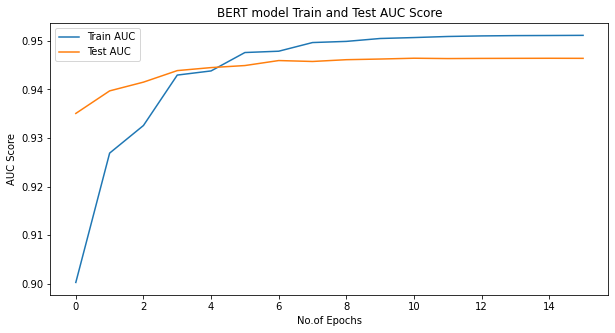

In [ ]:
# plotting BERT Model AUC Score history
fig, ax = plt.subplots(figsize = (10,5))
hist_3 = history_bert.history
plt.plot(range(len(hist_3["auc"])), hist_3["auc"], label = "Train AUC")
plt.plot(range(len(hist_3["val_auc"])), hist_3["val_auc"], label = "Test AUC")
plt.title('BERT model Train and Test AUC Score')
plt.xlabel('No.of Epochs')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

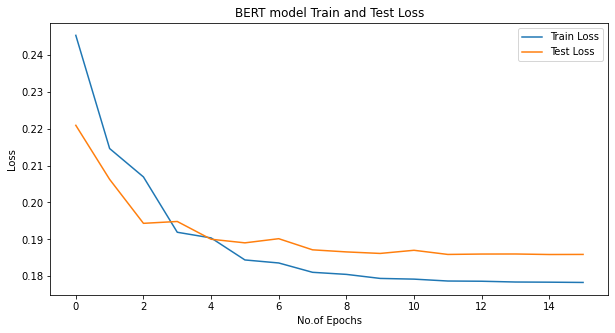

In [ ]:
# plotting BERT Model Loss history
fig, ax = plt.subplots(figsize = (10,5))
hist_3 = history_bert.history
plt.plot(range(len(hist_3["loss"])), hist_3["loss"], label = "Train Loss")
plt.plot(range(len(hist_3["val_loss"])), hist_3["val_loss"], label = "Test Loss")
plt.title('BERT model Train and Test Loss')
plt.xlabel('No.of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 7. Comparision of Models

In [1]:
from prettytable import PrettyTable

myTable= PrettyTable(["Deep Learning Models", "Train AUC Score", "Test AUC Score"])
# adding rows
myTable.add_row(["W2V + LSTM", "0.9768", "0.9790"])
myTable.add_row(["W2V + Bi-Directional LSTM", "0.9671", "0.9769"])
myTable.add_row(["BERT", "0.9511", "0.9464"])

print(myTable)

+---------------------------+-----------------+----------------+
|    Deep Learning Models   | Train AUC Score | Test AUC Score |
+---------------------------+-----------------+----------------+
|         W2V + LSTM        |      0.9768     |     0.9790     |
| W2V + Bi-Directional LSTM |      0.9671     |     0.9769     |
|            BERT           |      0.9511     |     0.9464     |
+---------------------------+-----------------+----------------+


Here the LSTM model with pre trained W2V vectors gives best AUC score for our dataset.